<a href="https://colab.research.google.com/github/hc0rd31r0/Bootcamp_Data_Science/blob/main/Bootcamp_DataScience_final_modulo3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projeto Módulo 3 - Bootcamp Data Science Aplicada 2 by [Alura](https://www.alura.com.br/) 

Autor: Helton Cordeiro

e-mail: heltoncordeiro@gmail.com


---

# **Objetivo da análise**

Vamos analisar a evolução da pandemia da COVID-19 no Estado do Paraná e utilizar  técnicas de Machine Learning para traçar uma previsão para a evolução da doença. 

---

##Importação de bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates  as mdates

import datetime as dt
import warnings
warnings.simplefilter(action='ignore')

from pandas.plotting import autocorrelation_plot

from fbprophet.diagnostics import cross_validation
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_plotly, plot_components_plotly

from sklearn.metrics import mean_absolute_error
import logging

## Configurações iniciais

In [2]:
logging.getLogger('fbprophet').setLevel(logging.WARNING)
pd.options.display.float_format = "{:,.2f}".format
sns.set()
sns.set_style("ticks")

mpl.rcParams['figure.figsize']= (16,8)
mpl.rcParams['figure.titlesize']= 18
mpl.rcParams['figure.titleweight']= 'bold'
mpl.rcParams['axes.labelsize']= 16
mpl.rcParams['axes.titlesize']= 18
mpl.rcParams['axes.titleweight']= 'bold'
mpl.rcParams['xtick.labelsize']= 11
mpl.rcParams['ytick.labelsize']= 11
mpl.rcParams['legend.fontsize']= 'large'
mpl.rcParams['date.autoformatter.day']= '%d/%m/%Y'
mpl.rcParams['grid.color']='grey'
mpl.rcParams['grid.linestyle']= '--'
mpl.rcParams['grid.linewidth']= 0.5

##Carregando e tratando os Dados

---

Informações obtidas do site [Brasil.IO](https://brasil.io/dataset/covid19/caso_full/)

**Dados obtidos em 30/06/2021**.

*   **Arquivo casos-full**: https://github.com/hc0rd31r0/Bootcamp_Data_Science/blob/main/projeto-modulo-03/dados/caso_full.csv.gz?raw=true


---



### Realizando a carga de dados

In [3]:
casos_full_raw = pd.read_csv("https://github.com/hc0rd31r0/Bootcamp_Data_Science/blob/main/projeto-modulo-03/dados/caso_full.csv.gz?raw=true", 
                               engine='python', compression='gzip', sep=",", thousands=".", decimal=",")

### Informações sobre a base de dados

In [4]:
display(casos_full_raw.shape)
display(print(40*"--x"))
display(casos_full_raw.info())
display(print(40*"--x"))
display(casos_full_raw.head())
display(print(40*"--x"))
# display(casos_full_raw.tail())
# display(print(50*"--x"))

(2331712, 18)

--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331712 entries, 0 to 2331711
Data columns (total 18 columns):
 #   Column                                         Dtype  
---  ------                                         -----  
 0   city                                           object 
 1   city_ibge_code                                 float64
 2   date                                           object 
 3   epidemiological_week                           int64  
 4   estimated_population                           float64
 5   estimated_population_2019                      float64
 6   is_last                                        bool   
 7   is_repeated                                    bool   
 8   last_available_confirmed                       int64  
 9   last_available_confirmed_per_100k_inhabitants  float64
 10  last_available_date                            object 
 11  last_available_death_rate                      int64  
 12  last_available_deaths                     

None

--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x


None

,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
0,Rio Branco,"1,200,401.00",2020-03-17,202012,"413,418.00","407,319.00",False,False,3,"72,566.00",2020-03-17,0,0,1,city,AC,3,0
1,NaN,12.00,2020-03-17,202012,"894,470.00","881,935.00",False,False,3,"33,539.00",2020-03-17,0,0,1,state,AC,3,0
2,Rio Branco,"1,200,401.00",2020-03-18,202012,"413,418.00","407,319.00",False,False,3,"72,566.00",2020-03-18,0,0,2,city,AC,0,0
3,NaN,12.00,2020-03-18,202012,"894,470.00","881,935.00",False,False,3,"33,539.00",2020-03-18,0,0,2,state,AC,0,0
4,Rio Branco,"1,200,401.00",2020-03-19,202012,"413,418.00","407,319.00",False,False,4,"96,754.00",2020-03-19,0,0,3,city,AC,1,0


--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x--x


None

### Adicionando informações de região e ajustando o campo data

In [5]:
dados_full = casos_full_raw.copy()

In [6]:
# Adicionando informação de região
regioes_dic = {
            'Norte' : ['RO','AC','AM','RR','PA','AP','TO' ],
            'Nordeste': ['MA','PI','CE','RN','PB','PE','AL','SE','BA'],
            'Sudeste' : ['MG','ES','RJ','SP'],
            'Sul' : ['PR','SC','RS'],
            'Centro-Oeste' : ['MS','MT','GO','DF']
           }

regioes = []
for estado in dados_full['state']:
  for regiao, uf in regioes_dic.items():
    if estado in uf:
      regioes.append(regiao)
   
dados_full['regiao'] = regiao

#informar ao pandas que as colunas 'date' e 'last_available_date' são do tipo datetime
dados_full['date'] = pd.to_datetime(casos_full_raw['date'], format='%Y-%m-%d')

### Separando informações populacionais

In [7]:
#Separar as informações populacionais
info_populacao = dados_full[dados_full.place_type.eq('state')]
info_populacao = info_populacao[['state','regiao','estimated_population']].drop_duplicates()
info_populacao.columns=['uf', 'regiao', 'populacao_estimada']
info_populacao = info_populacao.set_index("uf")

### Renomeando e separando as colunas

Vamos separar e renomear as colunas que interessam para a análise.


In [8]:
dados = dados_full[['date', 'regiao','state','city','estimated_population','place_type','new_confirmed','new_deaths', 'is_repeated']]
dados.columns=['data', 'regiao','uf','cidade','populacao_estimada','tipo_local', 'casos_novos', 'obitos_novos', 'repetido']
dados

,data,regiao,uf,cidade,populacao_estimada,tipo_local,casos_novos,obitos_novos,repetido
0,2020-03-17,Centro-Oeste,AC,Rio Branco,"413,418.00",city,3,0,False
1,2020-03-17,Centro-Oeste,AC,NaN,"894,470.00",state,3,0,False
2,2020-03-18,Centro-Oeste,AC,Rio Branco,"413,418.00",city,0,0,False
3,2020-03-18,Centro-Oeste,AC,NaN,"894,470.00",state,0,0,False
4,2020-03-19,Centro-Oeste,AC,Rio Branco,"413,418.00",city,1,0,False
...,...,...,...,...,...,...,...,...,...
2331707,2021-06-29,Centro-Oeste,TO,Tupirama,"1,922.00",city,0,0,True
2331708,2021-06-29,Centro-Oeste,TO,Tupiratins,"2,729.00",city,0,0,True
2331709,2021-06-29,Centro-Oeste,TO,Wanderlândia,"11,734.00",city,0,0,True
2331710,2021-06-29,Centro-Oeste,TO,Xambioá,"11,520.00",city,0,0,True


### Criando DataFrame com os dados do Estado do Paraná

In [9]:
dados_PR = dados.query('uf == "PR" and tipo_local =="state"').reset_index()
dados_PR = dados_PR[['data', 'regiao','uf','cidade','populacao_estimada','tipo_local', 'casos_novos', 'obitos_novos', 'repetido']]
dados_PR

,data,regiao,uf,cidade,populacao_estimada,tipo_local,casos_novos,obitos_novos,repetido
0,2020-03-12,Centro-Oeste,PR,NaN,"11,516,840.00",state,6,0,False
1,2020-03-13,Centro-Oeste,PR,NaN,"11,516,840.00",state,0,0,False
2,2020-03-14,Centro-Oeste,PR,NaN,"11,516,840.00",state,0,0,True
3,2020-03-15,Centro-Oeste,PR,NaN,"11,516,840.00",state,0,0,True
4,2020-03-16,Centro-Oeste,PR,NaN,"11,516,840.00",state,0,0,False
...,...,...,...,...,...,...,...,...,...
470,2021-06-25,Centro-Oeste,PR,NaN,"11,516,840.00",state,8231,43,False
471,2021-06-26,Centro-Oeste,PR,NaN,"11,516,840.00",state,5692,57,False
472,2021-06-27,Centro-Oeste,PR,NaN,"11,516,840.00",state,4696,7,False
473,2021-06-28,Centro-Oeste,PR,NaN,"11,516,840.00",state,5000,6,False


###Verificando os repetidos e zerados

Verificando quantos registros repetidos temos no dataFrame para avaliar se podem afetar nossa análise

In [10]:
dados_PR[dados_PR.repetido.eq(True)]

,data,regiao,uf,cidade,populacao_estimada,tipo_local,casos_novos,obitos_novos,repetido
2,2020-03-14,Centro-Oeste,PR,NaN,"11,516,840.00",state,0,0,True
3,2020-03-15,Centro-Oeste,PR,NaN,"11,516,840.00",state,0,0,True


Apenas 2 (dois) registros duplicados não afetarão nossa análise.

In [11]:
dados_PR.query('casos_novos == 0')

,data,regiao,uf,cidade,populacao_estimada,tipo_local,casos_novos,obitos_novos,repetido
1,2020-03-13,Centro-Oeste,PR,NaN,"11,516,840.00",state,0,0,False
2,2020-03-14,Centro-Oeste,PR,NaN,"11,516,840.00",state,0,0,True
3,2020-03-15,Centro-Oeste,PR,NaN,"11,516,840.00",state,0,0,True
4,2020-03-16,Centro-Oeste,PR,NaN,"11,516,840.00",state,0,0,False
136,2020-07-26,Centro-Oeste,PR,NaN,"11,516,840.00",state,0,18,False


5 (cinco) registros zerados de casos novos comunicados sendo 4 deles em Março de 2020, como veremos os 4 (quatro) primeiros meses de 2020 a situação estava controlada. 

### Criando novas colunas com informações para estudo

A fim de apurar o tempo médio entre a contaminação e o óbitos, busquei informações na mídia sobre o assunto.

* Segunda essa matéria do [Amazonas atual](https://amazonasatual.com.br/tempo-medio-entre-o-inicio-dos-sintomas-e-morte-por-covid-19-e-de-12-dias-diz-fvs/), o tempo médio entre o início dos sintomas e morte por Covid-19 é de **12 dias**, diz FVS (Fundação de Vigilância em Saúde do Amazonas) - 20/05/2020

* Esse outra matéria do [IG](https://saude.ig.com.br/2020-07-24/em-media-covid-19-leva-15-dias-para-matar-pacientes-no-brasil-aponta-estudo.html) informa que em média, Covid-19 leva **15 dias** para matar pacientes no Brasil - 24/07/2020

* Nessa matéria do [Diário do Nordeste](https://diariodonordeste.verdesmares.com.br/metro/tempo-medio-entre-inicio-de-sintomas-e-morte-por-covid-no-ceara-e-10-dias-maior-na-segunda-onda-1.3097493) o tempo médio entre início de sintomas e morte por Covid no Ceará é de 10 (dez) dias maior na segunda onda, em 2021, intervalo entre primeiros sinais da doença e o óbito do paciente é de **28 dias** - 15/06/2021


Considerando as matérias acima, vamos criar colunas com o registro de óbitos de acordo com os dias médios apresentados, além de campos para os casos acumulados e a média móvel de 10 dias, além da taxa de crescimento de casos e óbitos.


In [12]:
dados_PR['casos_acumulados'] = dados_PR['casos_novos'].cumsum()
dados_PR['obitos_acumulados'] = dados_PR['obitos_novos'].cumsum()

dados_PR['media_movel_casos'] = dados_PR['casos_novos'].rolling(window=10).mean()
dados_PR['media_movel_obitos'] = dados_PR['obitos_novos'].rolling(window=10).mean()

dados_PR['taxa_de_crescimento_casos'] = dados_PR['casos_novos'].diff()
dados_PR['taxa_de_crescimento_obitos'] = dados_PR['obitos_novos'].diff()

dados_PR['obitosNovos7'] = dados_PR['obitos_novos'].shift(-7)
dados_PR['obitosNovos12'] = dados_PR['obitos_novos'].shift(-12)
dados_PR['obitosNovos15'] = dados_PR['obitos_novos'].shift(-15)
dados_PR['obitosNovos28'] = dados_PR['obitos_novos'].shift(-28)

dados_PR['ano'] = pd.DatetimeIndex(dados_PR.data).year
dados_PR['mes'] = pd.DatetimeIndex(dados_PR.data).month

#Evolução da COVID-19 no Estado do Paraná

**Dados gerais do Paraná**
* Região: **Sul**.
* Capital: **Curitiba**.
* Área territorial: **199.315 km²** (IBGE, 2019).
* População: **11.516.840 habitantes** (IBGE, 2020).
* Densidade demográfica: **52,4 hab./km²** (IBGE, 2010).
* Fuso: **UTC-3**.
* Clima: **subtropical**.



A 11a semana epidemiológica de 2020 já se encaminhava para o fim quando, em uma quinta-feira, 12 de março, os primeiros seis casos de Covid-19 foram confirmados no Paraná. Cinco moradores de Curitiba e uma de Cianorte (Noroeste), todos vindos de viagens internacionais, tiveram o diagnóstico positivo para o novo coronavírus.

Até aquele momento, haviam 60 casos no Brasil, e o vírus identificado no finalzinho de 2019 na China já se espalhava por 116 países.

Foi exatamente no dia anterior, 11 de março, que a Organização Mundial da Saúde (OMS) mudou a classificação da doença e declarou a pandemia de Covid-19.

***E não tínhamos a menor ideia do que estava por vir.***

### Média Móvel de casos novos de COVID-19

Início do monitoramento e registro de ocorrências. No gráfico abaixo temos a evolução dos casos diarimente com a apresentação da média móvel.

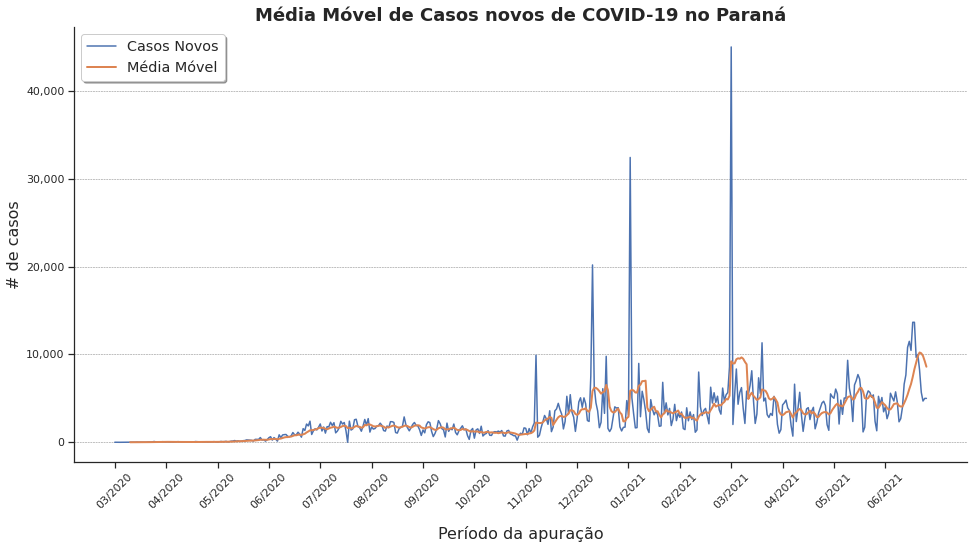

In [13]:
fig, ax = plt.subplots()
plt.title('Média Móvel de Casos novos de COVID-19 no Paraná')
sns.lineplot(x='data', y='casos_novos', data=dados_PR, ax=ax)
sns.lineplot(x='data', y='media_movel_casos', data=dados_PR, ax=ax, linewidth=2)
plt.xlabel('Período da apuração', labelpad=15)
plt.ylabel('# de casos')
plt.grid(axis='y')
plt.xticks(rotation=45)
sns.despine()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_major_locator(ticker.IndexLocator(base=30,offset=0))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.legend(labels=['Casos Novos', 'Média Móvel'], loc=2, frameon=True, shadow=True)
plt.show()

**Eramos felizes e não sabiámos.** 

Observando os dados de Março, Abril, Maio e Junho de 2020, os primeiros meses da pandemia, observamos as informaçoes próximas a 0 (zero) e podemos afirmar que as coisas estavam calmas, mas a partir de Novembro/2020 perdemoms o controle da situação, com 9.913 casos novos registrados em 13 de Novembro.

Os picos de casos apresentados no gráfico foram reportados a seguir:


####Tabela com os registros de 01/11/2020 até 31/03/2021 com mais de 8.000 (oito mil) casos novos.

In [14]:
df_tab = dados_PR[['data','casos_novos','obitos_novos']].query('data > "2020-11-01" and casos_novos > 8000 and data < "2021-03-31"').reset_index()
df_tab['data'] = df_tab['data'].dt.strftime('%d/%m/%Y')
df_tab

,index,data,casos_novos,obitos_novos
0,246,13/11/2020,9913,78
1,279,16/12/2020,20197,198
2,287,24/12/2020,9793,72
3,301,07/01/2021,32436,396
4,306,12/01/2021,8983,117
5,359,06/03/2021,8598,148
6,360,07/03/2021,45020,247
7,363,10/03/2021,8345,244
8,372,19/03/2021,8146,269
9,378,25/03/2021,11331,296


Vamos dar um ZOOM no gráfico acima, limitando nosso eixo (y) em 15.000 (quinze mil)

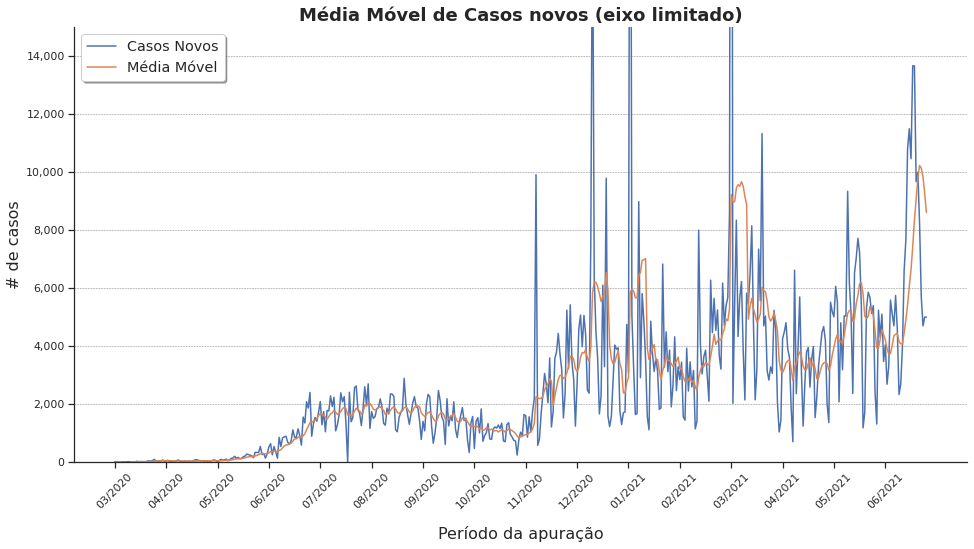

In [15]:
fig, ax = plt.subplots()
plt.title('Média Móvel de Casos novos (eixo limitado)')
sns.lineplot(x='data', y='casos_novos', data=dados_PR, ax=ax)
sns.lineplot(x='data', y='media_movel_casos', data=dados_PR, ax=ax)
plt.xlabel('Período da apuração', labelpad=15)
plt.ylabel('# de casos')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.ylim(0,15000)
sns.despine()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_major_locator(ticker.IndexLocator(base=30,offset=0))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.legend(labels=['Casos Novos', 'Média Móvel'], loc=2, frameon=True, shadow=True)
plt.show()

### Média Móvel de Óbitos

###**Os primeiros Alertas**
A primeira morte por COVID 19 no Brasil foi registrada no estado de São Paulo no dia 12 de março de 2020. No estado de Paraná, os primeiros 2 óbitos pela doença ocorreram em 27 de março de 2020.

Atualmente o número de óbitos acumulados pela COVID 19 no estado do Paraná é de 30510 (trinta mil, quinhento e dez) pessoas em 29/06/2021.

* Matéria [Gazeta do Povo](
https://www.gazetadopovo.com.br/parana/parana-primeiras-mortes-coronavirus/ 
) Paraná registra as duas primeiras mortes pelo novo coronavírus - 27/03/2020


* Matéria [Bem Paraná](https://www.bemparana.com.br/noticia/parana-e-o-segundo-estado-com-maior-media-movel-de-mortes-por-covid-19#.YN5raOhKiUk) - Paraná é o segundo estado com maior média móvel de mortes por Covid-19 - 06/06/2021

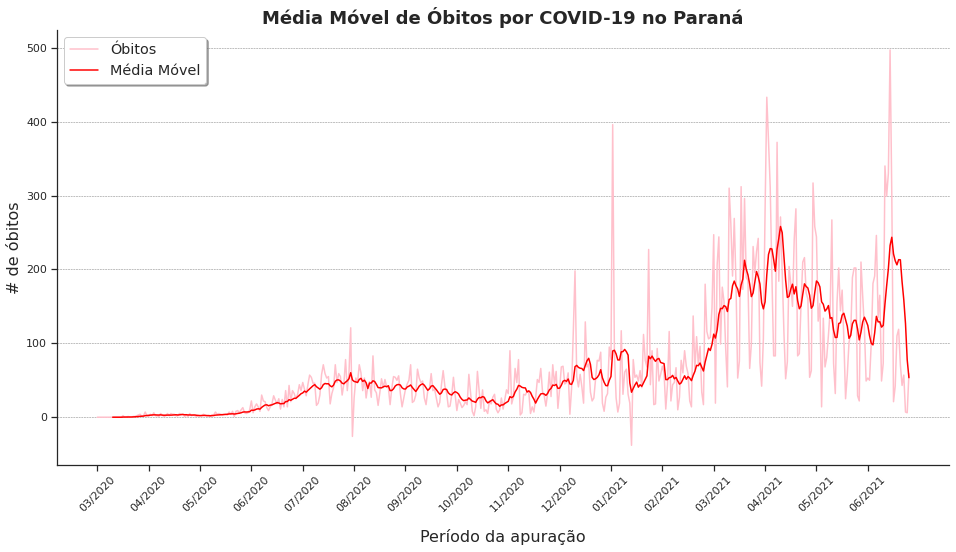

In [16]:
fig, ax = plt.subplots()
plt.title('Média Móvel de Óbitos por COVID-19 no Paraná')
sns.lineplot(x='data', y='obitos_novos', data=dados_PR, ax=ax, color='Pink')
sns.lineplot(x='data', y='media_movel_obitos', data=dados_PR, ax=ax, color='red')
sns.despine()
plt.xlabel('Período da apuração', labelpad=15)
plt.ylabel('# de óbitos')
plt.grid(axis='y')
plt.xticks(rotation = 45)
ax.xaxis.set_major_locator(ticker.IndexLocator(base=30,offset=0))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.legend(labels=['Óbitos', 'Média Móvel'], loc=2, frameon=True, shadow=True)
plt.show()

### Médias Móveis (casos e óbitos)

Matéria [UOL](https://noticias.uol.com.br/saude/ultimas-noticias/bbc/2020/12/06/covid-19-por-que-pandemia-saiu-do-controle-no-parana.htm) - Covid-19: por que a pandemia saiu do controle no Paraná - 06/12/2020

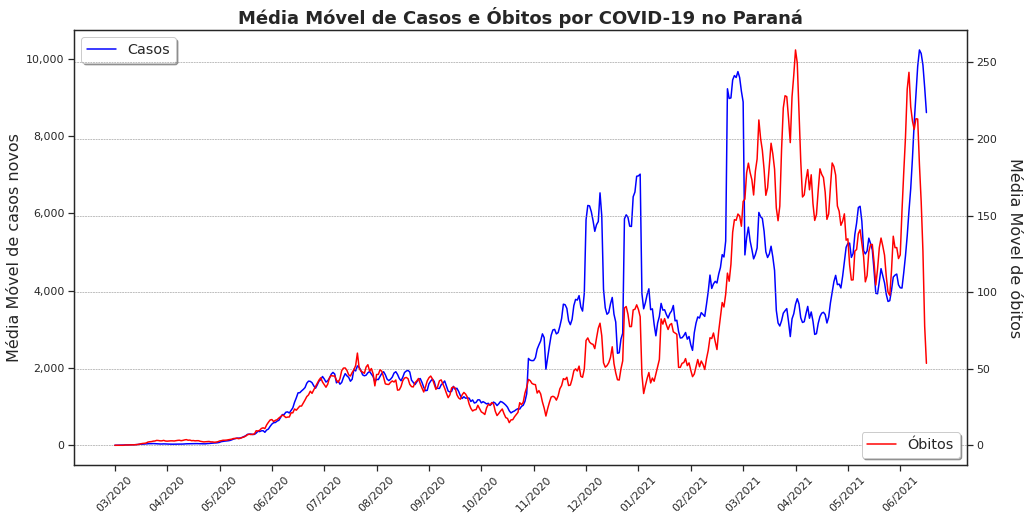

In [17]:
plt.title('Média Móvel de Casos e Óbitos por COVID-19 no Paraná')
ax1 = sns.lineplot(x='data', y='media_movel_casos', data=dados_PR, label='Casos', color='blue', legend=False)
ax1.set_ylabel('Média Móvel de casos novos')
ax1.set_xlabel('')
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax1.legend(loc=2, frameon=True, shadow=True)
plt.twinx()
ax2 = sns.lineplot(x='data', y='media_movel_obitos', data=dados_PR, label='Óbitos', color='red', legend=False )
ax2.set_ylabel('Média Móvel de óbitos', labelpad=25, rotation=270)
ax2.set_xlabel('Data da apuração')
ax2.xaxis.set_major_locator(ticker.IndexLocator(base=30,offset=0))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
for label in (ax1.get_xticklabels() + ax2.get_xticklabels()):    
  label.set_rotation(45)
plt.grid()
ax2.legend(loc=4, frameon=True, shadow=True)
plt.show()

Dois meses terríveis, Abril e Junho de 2021. Mesmo com a vacina a número de mortes aumentou consideravelmente.

Percebemos um grande aumento na taxa de óbitos em 2021.

### Casos Acumulados

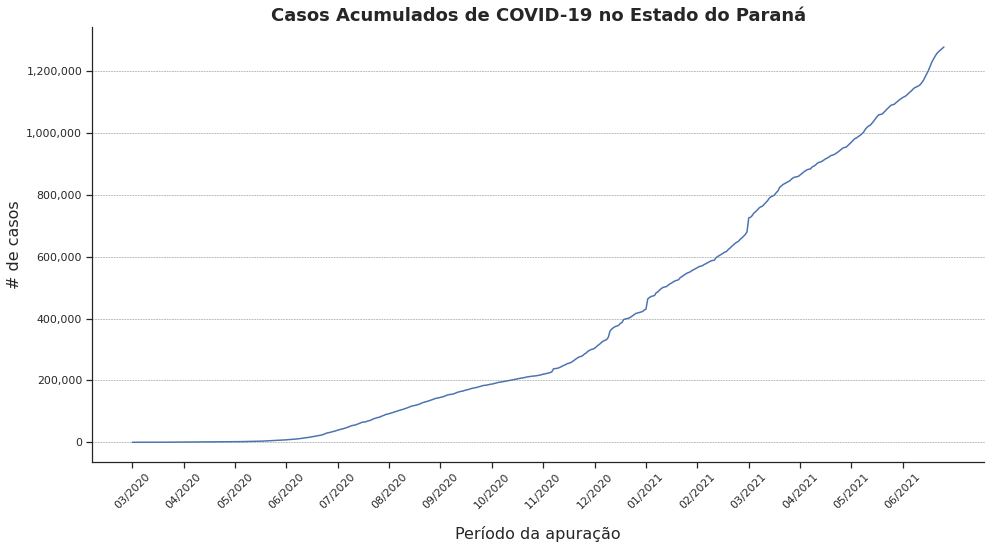

In [18]:
fig, ax = plt.subplots()
plt.title('Casos Acumulados de COVID-19 no Estado do Paraná')
sns.lineplot(x='data', y='casos_acumulados', data=dados_PR, ax=ax)
sns.despine()
plt.xlabel('Período da apuração', labelpad=15)
plt.ylabel('# de casos')
plt.grid(axis='y')
plt.xticks(rotation = 45)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_major_locator(ticker.IndexLocator(base=30,offset=0))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.show()

Vamos traçar um gráfico em escala exponencial para verificar se o crescimento dos casos acumulados tem esse comportamento.

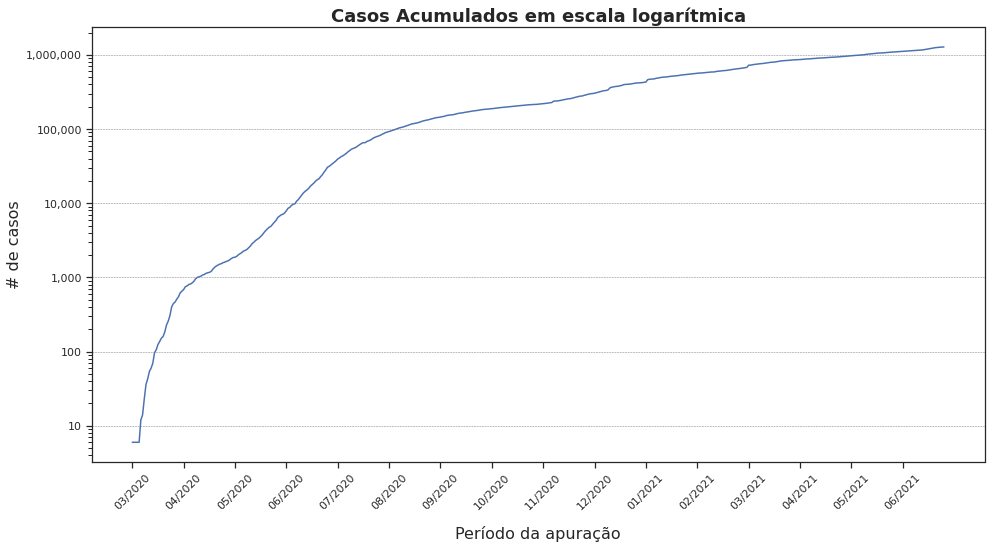

In [19]:
fig, ax = plt.subplots()
sns.lineplot(x='data', y='casos_acumulados', data=dados_PR, ax=ax)
plt.title('Casos Acumulados em escala logarítmica')
plt.xlabel('Período da apuração', labelpad=15)
plt.ylabel('# de casos')
plt.grid(axis='y')
plt.xticks(rotation = 45)
plt.yscale('log')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_major_locator(ticker.IndexLocator(base=30,offset=0))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.show()

Não é uma reta perfeita como o experado para uma comprovação de crescimento exponencial, mas podemos verificar vários segmentos de reta que nos mostram um crescimento exponencial desordenado.

### Vamos buscar alguma Sazonalidade

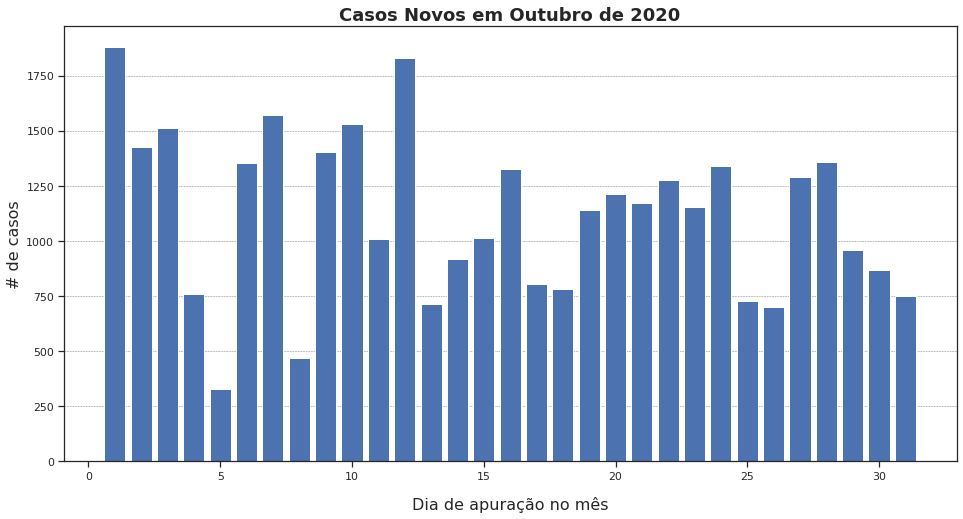

In [20]:
fig, ax = plt.subplots()
dados_PR_1 = dados_PR.query('mes == 10 and ano == 2020')
plt.title('Casos Novos em Outubro de 2020')
plt.bar(np.linspace(1,31,31), dados_PR_1['casos_novos'])
plt.ylabel('# de casos')
plt.xlabel('Dia de apuração no mês', labelpad=15)
plt.grid(axis='y')
plt.show()

Visualmente não consigo identificar nenhuma sazonalidade. No eixo (x) temos os dias de outubro e no dia 5 (segunda-feira) temos uma queda no registros de casos, dia 8 (quinta-feira) também, dia 12 de outubro, além de ser segunda-feira ainda foi feriado, portanto, vou deixar para o nosso modelo de Machine Learning identificar possível sazonalidade no histórico de dados.

## Correlação


Vamos buscar alguma correlação entre o número de casos novos com os números de óbitos novos. Quanto mais próximo de 1 ou -1, maior é a correlação.

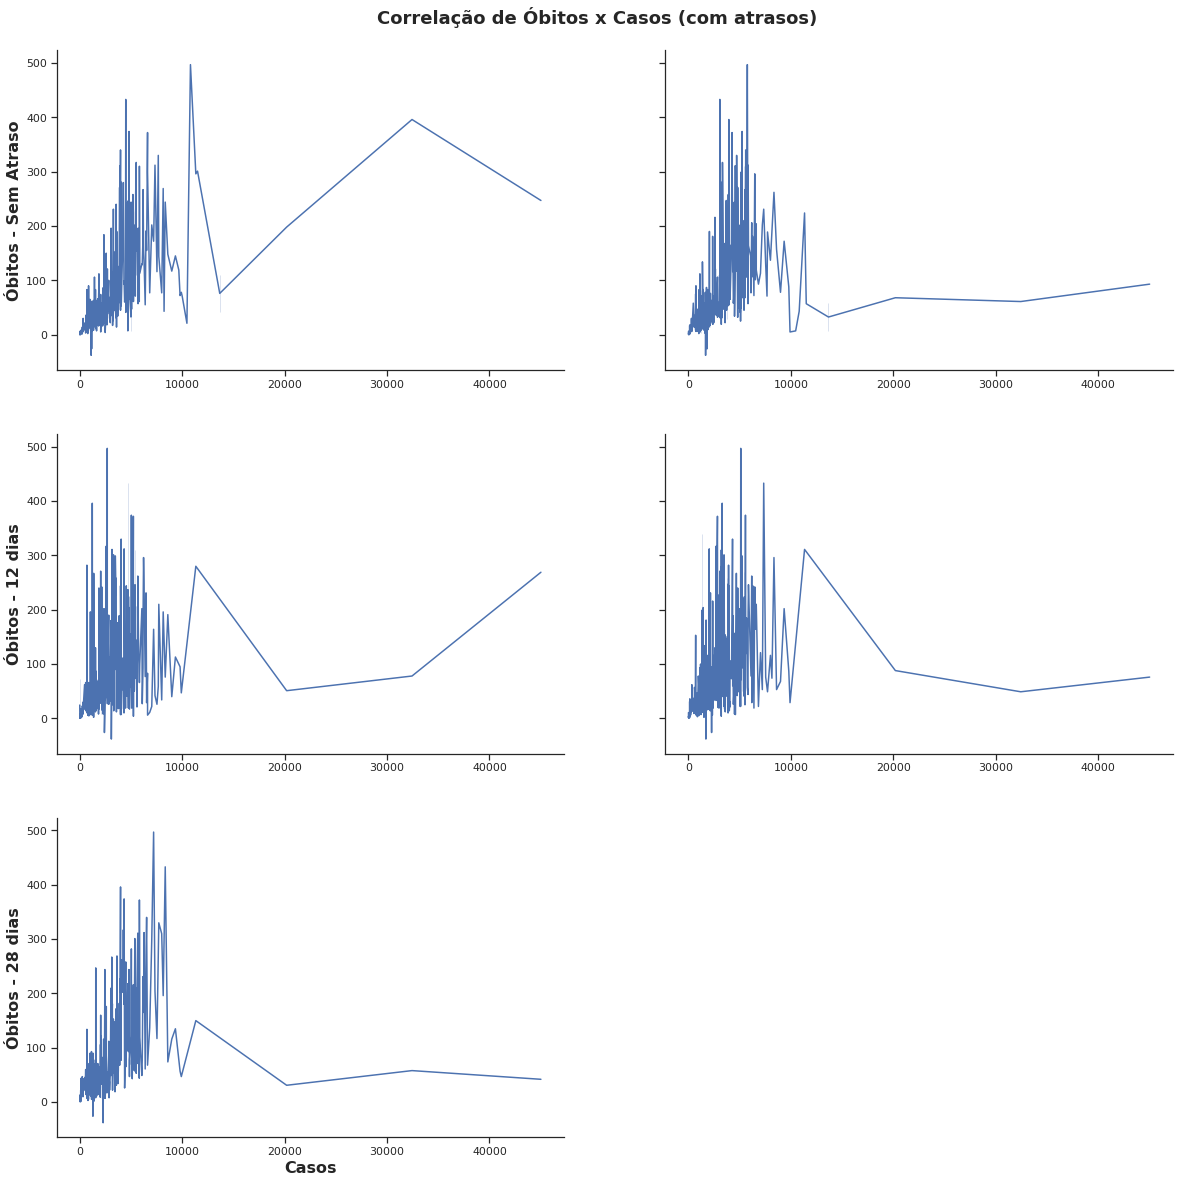

In [21]:
fig, axs = plt.subplots(3, 2, sharex=False, sharey=True, figsize=(20,20))

plt.suptitle('Correlação de Óbitos x Casos (com atrasos)', y=0.91)

sns.lineplot(x = 'casos_novos', y='obitos_novos', data=dados_PR, ax=axs[0,0])
axs[0,0].set_ylabel('Óbitos - Sem Atraso', weight='bold')
axs[0,0].set_xlabel('')

sns.lineplot(x='casos_novos', y='obitosNovos7', data=dados_PR, ax=axs[0,1])
axs[0,1].set_ylabel('Óbitos - 7 dias', weight='bold')
axs[0,1].set_xlabel('')

sns.lineplot(x='casos_novos', y='obitosNovos12', data=dados_PR, ax=axs[1,0])
axs[1,0].set_ylabel('Óbitos - 12 dias', weight='bold')
axs[1,0].set_xlabel('')

sns.lineplot(x='casos_novos', y='obitosNovos15', data=dados_PR, ax=axs[1,1])
axs[1,1].set_ylabel('Óbitos - 15 dias', weight='bold')
axs[1,1].set_xlabel('')

sns.lineplot(x='casos_novos',  y='obitosNovos28',data=dados_PR, ax=axs[2,0])
axs[2,0].set_ylabel('Óbitos - 28 dias', weight='bold')
axs[2,0].set_xlabel('Casos', weight='bold')

sns.despine()
axs[2,1].set_visible(False)
plt.show()

###Tabela de Correlação

In [22]:
dados_PR_corr = dados_PR[['casos_novos','obitos_novos','obitosNovos7','obitosNovos12','obitosNovos15','obitosNovos28']].corr()
pd.options.display.float_format = "{:,.5f}".format
display(dados_PR_corr)
pd.options.display.float_format = "{:,.2f}".format

,casos_novos,obitos_novos,obitosNovos7,obitosNovos12,obitosNovos15,obitosNovos28
casos_novos,1.00000,0.60561,0.39741,0.36690,0.34140,0.40737
obitos_novos,0.60561,1.00000,0.67471,0.42971,0.56802,0.62936
obitosNovos7,0.39741,0.67471,1.00000,0.46940,0.56117,0.71114
obitosNovos12,0.36690,0.42971,0.46940,1.00000,0.46135,0.47974
obitosNovos15,0.34140,0.56802,0.56117,0.46135,1.00000,0.53986
obitosNovos28,0.40737,0.62936,0.71114,0.47974,0.53986,1.00000


A maior valor de correlação é observada entre os casos novos e óbitos novos.


A quantidade de casos novos verificados nos picos estão distorcendo a análise desta correlação, vamos limitar os casos em até 10.000 (dez mil), pois temos apenas 4 ocorrências acima desse valor, para verificar como ficam nos gráficos.

### Casos abaixo de dez mil para reavaliação

In [23]:
dados_PR_less = dados_PR.query('casos_novos < 10000')

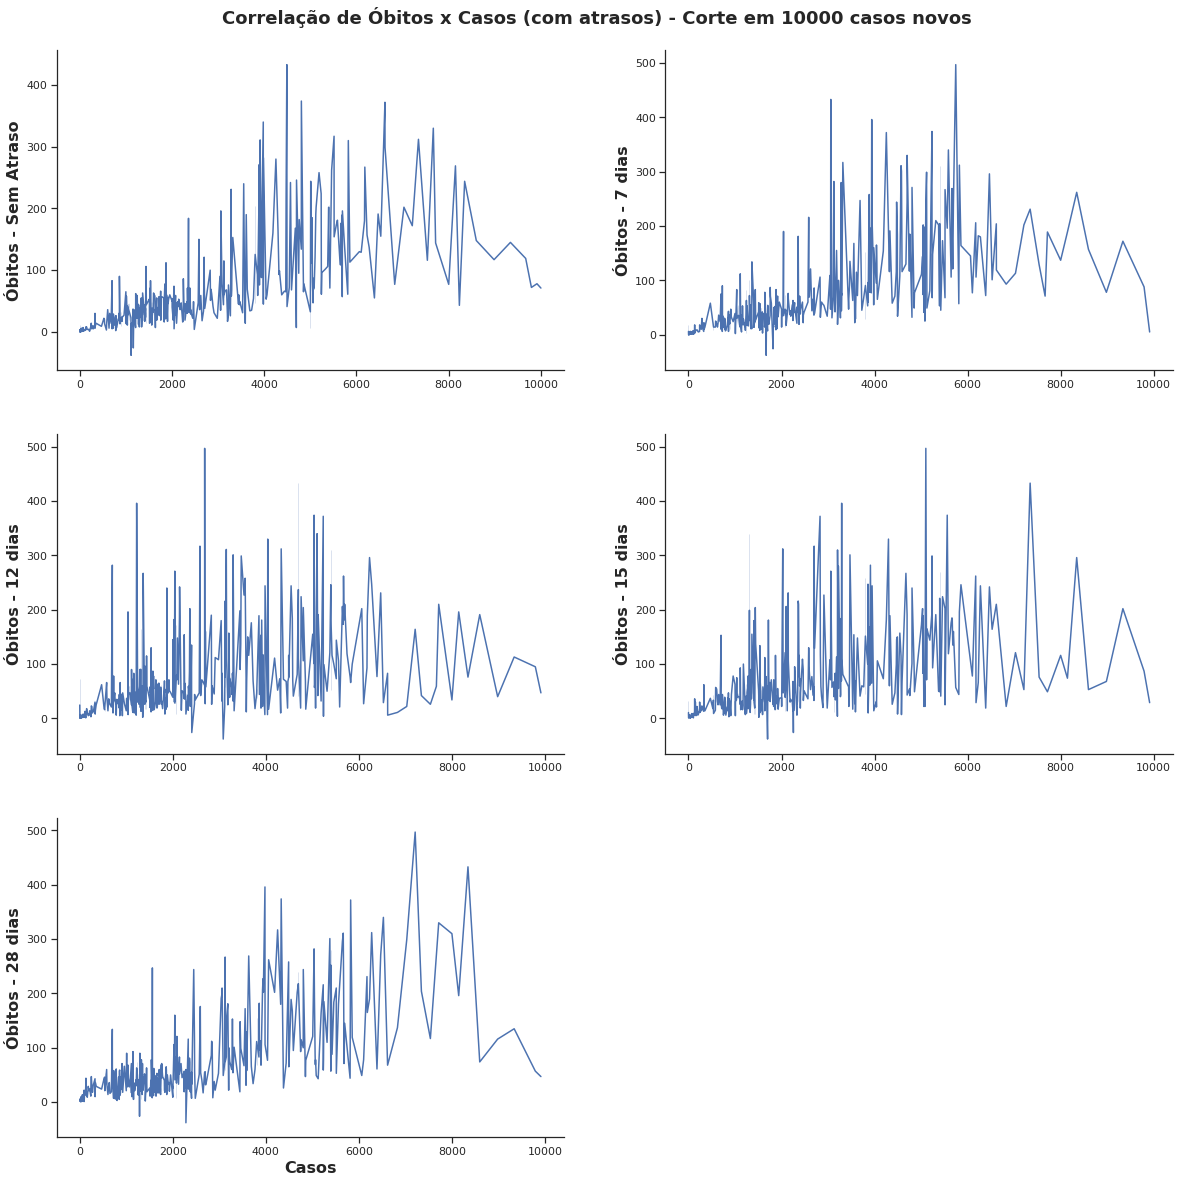

In [24]:
fig, axs = plt.subplots(3, 2, figsize=(20,20))

plt.suptitle('Correlação de Óbitos x Casos (com atrasos) - Corte em 10000 casos novos', y=0.91)

sns.lineplot(x = 'casos_novos', y='obitos_novos', data=dados_PR_less, ax=axs[0,0])
axs[0,0].set_ylabel('Óbitos - Sem Atraso', weight='bold')
axs[0,0].set_xlabel('')

sns.lineplot(x='casos_novos', y='obitosNovos7', data=dados_PR_less, ax=axs[0,1])
axs[0,1].set_ylabel('Óbitos - 7 dias', weight='bold')
axs[0,1].set_xlabel('')

sns.lineplot(x='casos_novos', y='obitosNovos12', data=dados_PR_less, ax=axs[1,0])
axs[1,0].set_ylabel('Óbitos - 12 dias', weight='bold')
axs[1,0].set_xlabel('')

sns.lineplot(x='casos_novos', y='obitosNovos15', data=dados_PR_less, ax=axs[1,1])
axs[1,1].set_ylabel('Óbitos - 15 dias', weight='bold')
axs[1,1].set_xlabel('')

sns.lineplot(x='casos_novos',  y='obitosNovos28',data=dados_PR_less, ax=axs[2,0])
axs[2,0].set_ylabel('Óbitos - 28 dias', weight='bold')
axs[2,0].set_xlabel('Casos', weight='bold')

sns.despine()
axs[2,1].set_visible(False)
plt.show()

###Tabela de Correlação 2 

In [25]:
dados_PR_less_corr = dados_PR_less[['casos_novos','obitos_novos','obitosNovos7','obitosNovos12','obitosNovos15','obitosNovos28']].corr()
pd.options.display.float_format = "{:,.5f}".format
display(dados_PR_less_corr)
pd.options.display.float_format = "{:,.2f}".format

,casos_novos,obitos_novos,obitosNovos7,obitosNovos12,obitosNovos15,obitosNovos28
casos_novos,1.00000,0.69745,0.66042,0.45808,0.52859,0.69155
obitos_novos,0.69745,1.00000,0.72657,0.42128,0.57884,0.65927
obitosNovos7,0.66042,0.72657,1.00000,0.46501,0.55605,0.71166
obitosNovos12,0.45808,0.42128,0.46501,1.00000,0.45448,0.48461
obitosNovos15,0.52859,0.57884,0.55605,0.45448,1.00000,0.54014
obitosNovos28,0.69155,0.65927,0.71166,0.48461,0.54014,1.00000


Limitado a 10000 (dez mil) casos as maiores correlações são observadas com os óbitos novos (**0,697451**) e com óbitos após 28 dias (**0,691547**).

### Autocorrelação entre os Casos novos e Óbitos

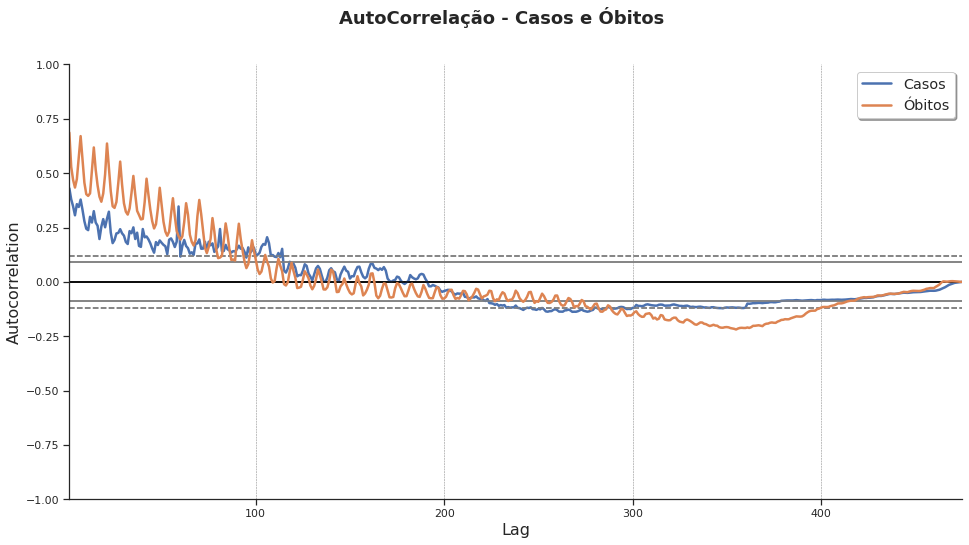

In [26]:
#Plotando autocorrelação - Casos e Óbitos
plt.suptitle('AutoCorrelação - Casos e Óbitos')
autocorrelation_plot(dados_PR['casos_novos'], linewidth=2.5, label='Casos')
autocorrelation_plot(dados_PR['obitos_novos'], linewidth=2.5, label='Óbitos')
plt.legend(frameon=True, shadow=True)
plt.grid(axis='x')
sns.despine()
plt.show()

Sobre a autocorrelação entre os número de casos novos e óbitos novos visualizamos que se relacionam até os primeiros 100 (cem) dias, com um pico próximo ao dia 110 (cento e dez), mas diminuindo com o passar do tempo.

### Correlação Cruzada entre Casos e óbitos novos.

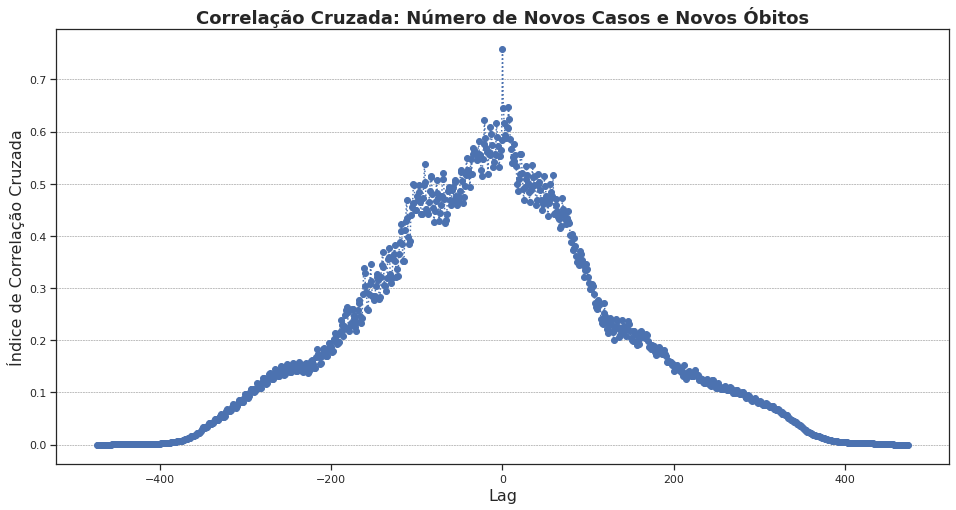

In [27]:
df_plot = dados_PR[['casos_novos','obitos_novos']]
plt.xcorr(x=df_plot['casos_novos'].astype(float), y=df_plot['obitos_novos'].astype(float), maxlags=None, usevlines=False, linestyle=':', linewidth=1.5)
plt.grid(axis='y')
plt.ylabel('Índice de Correlação Cruzada')
plt.xlabel('Lag')
plt.title('Correlação Cruzada: Número de Novos Casos e Novos Óbitos', fontweight='bold')
plt.show()

# Análise Temporal

Segue definição da [Wikipedia](https://pt.wikipedia.org/wiki/S%C3%A9rie_temporal) para séries temporais:

*Em estatística, econometria, matemática aplicada e processamento de sinais, uma série temporal é uma coleção de observações feitas sequencialmente ao longo do tempo. Em modelos de regressão linear com dados cross-section a ordem das observações é irrelevante para a análise, em séries temporais a ordem dos dados é fundamental. Uma característica muito importante deste tipo de dados é que as observações vizinhas são dependentes e o interesse é analisar e modelar essa dependência.*

### Preparando dataFrame para o Prophet()

In [28]:
df = dados_PR[['data','casos_novos']]
df.columns = ['ds','y']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      475 non-null    datetime64[ns]
 1   y       475 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 7.5 KB


### Funções para processar o modelo e plotar o modelo e os componentes

In [29]:
# A função criar a previsão, df de treino e teste
# recebe o modelo a ser utilizado
# recebe o df: Dataframe completo, separando 70%/30% para treino/teste
# recebe o período de previsão (forecast)
# retorna: previsao, df_treino, df_teste
def processar_modelo(modelo, df: pd.DataFrame, previsao: int):
  numTreino = int(df.shape[0] * 0.7)
  numTeste  = (df.shape[0] - numTreino)
  # 70%
  df_treino = pd.DataFrame()
  df_treino['ds'] = df['ds'][:numTreino]
  df_treino['y']  = df['y'][:numTreino]
  # 30%
  df_teste = pd.DataFrame()
  df_teste['ds'] = df['ds'][numTreino:]
  df_teste['y']  = df['y'][numTreino:]
  
  # Treinando o modelo com 80% dos dados
  modelo.fit(df_treino)
  # Gerando a previsão
  previsao = modelo.predict(modelo.make_future_dataframe(periods=previsao))
  
  return previsao, df_treino, df_teste

In [30]:
# Função genérica para plotar o modelo
def plotar_modelo(modelo, previsao,  df_teste:pd.DataFrame=None, show_change_points=True):
  fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
  modelo.plot(previsao, xlabel='Data', ylabel='Casos Novos', ax=ax);
  if (df_teste is not None):
    plt.plot(df_teste['ds'],df_teste['y'],'.r')
  if show_change_points:
    a=add_changepoints_to_plot(fig.gca(), modelo, previsao, cp_color='r')
  plt.xticks(rotation = 45)
  ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
  ax.xaxis.set_major_locator(ticker.IndexLocator(base=30,offset=0))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
  labels=['Casos novos - Treino','Curva ajustada','Casos novos - Teste','Região de intervalo de confiança']
  plt.legend(labels=labels, loc=2, shadow=True)
  plt.show()

In [31]:
# Função para plotar os componentes, com ajustes da versão original.
# Autor: Leonardo Barros Mendonça
# Source original: https://github.com/leobmend/Alura-Bootcamp-DataScience/blob/main/modulo_03/alurabcds_mod03_aula04.ipynb
# 
def plotar_componentes(modelo, previsao, figsize=(16,10)):
  fig = modelo.plot_components(previsao, figsize=figsize)
  axs = fig.get_axes()
  axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
  axs[0].set_xlabel('Mês', labelpad=5)
  axs[0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
  axs[0].set_ylabel('Casos Novos',labelpad=10)
  axs[0].set_title('Tendência')

  axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
  axs[1].set_xlabel('Datas',labelpad=5)
  axs[1].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
  axs[1].set_ylabel('Casos Novos', labelpad=10)
  axs[1].set_title('Tendência em Feriados', pad=20)

  axs[2].set_xticklabels(["Domingo", "Segunda", "Terça", "Quarta", "Quinta", "Sexta", "Sábado"])
  axs[2].set_xlabel('Dia da Semana', labelpad=5)
  axs[2].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
  axs[2].set_ylabel('Casos Novos', labelpad=10)
  axs[2].set_title('Sazonalidade', pad=20)

  plt.tight_layout()
  plt.show()

### 1º Avaliação

Nesse avaliação vamos utilizar o modelo do Prophet() padrão, sem nenhum ajuste e com os feriados do Brasil.

In [32]:
modelo1 = Prophet()
modelo1.add_country_holidays(country_name='BR')
previsao1, dados_treino1, dados_teste1 = processar_modelo(modelo1, df, 143)

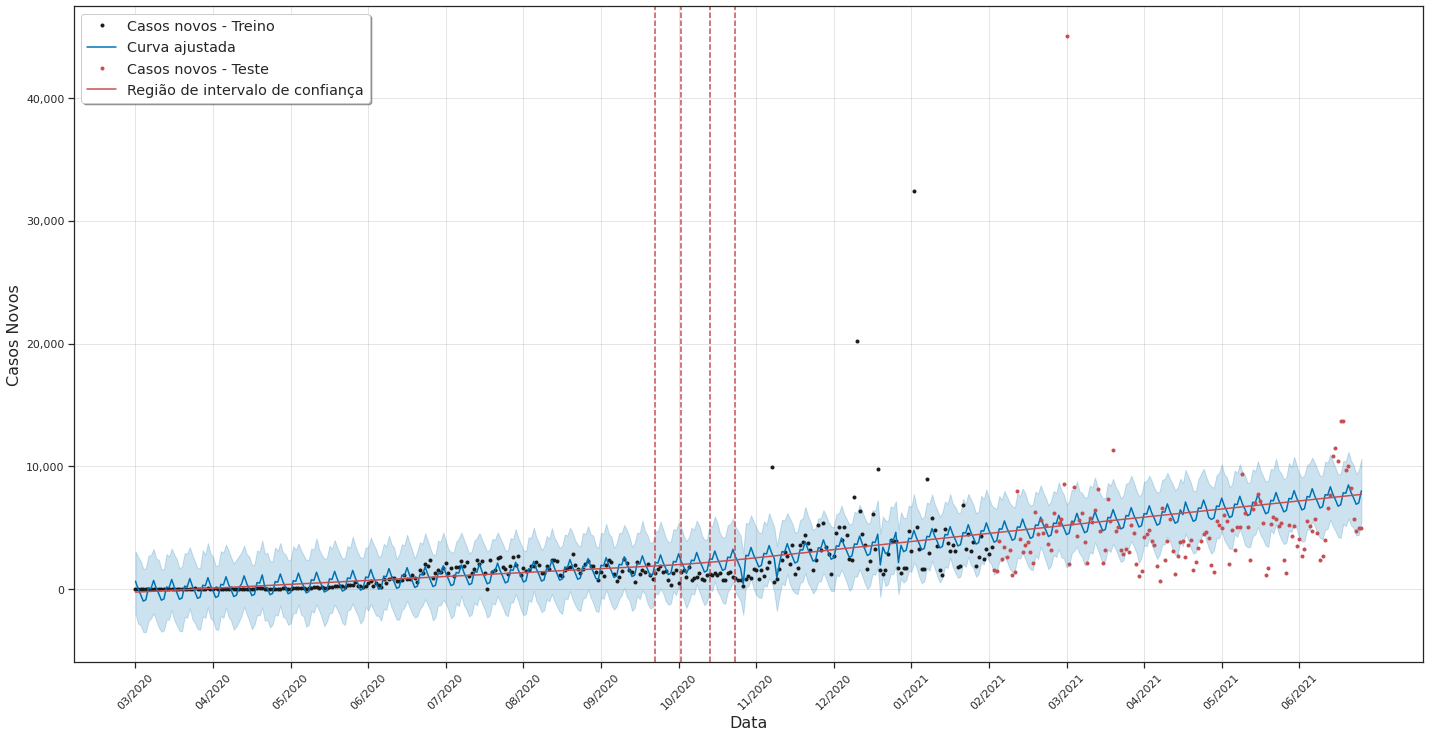

In [33]:
plotar_modelo(modelo1, previsao1, dados_teste1)

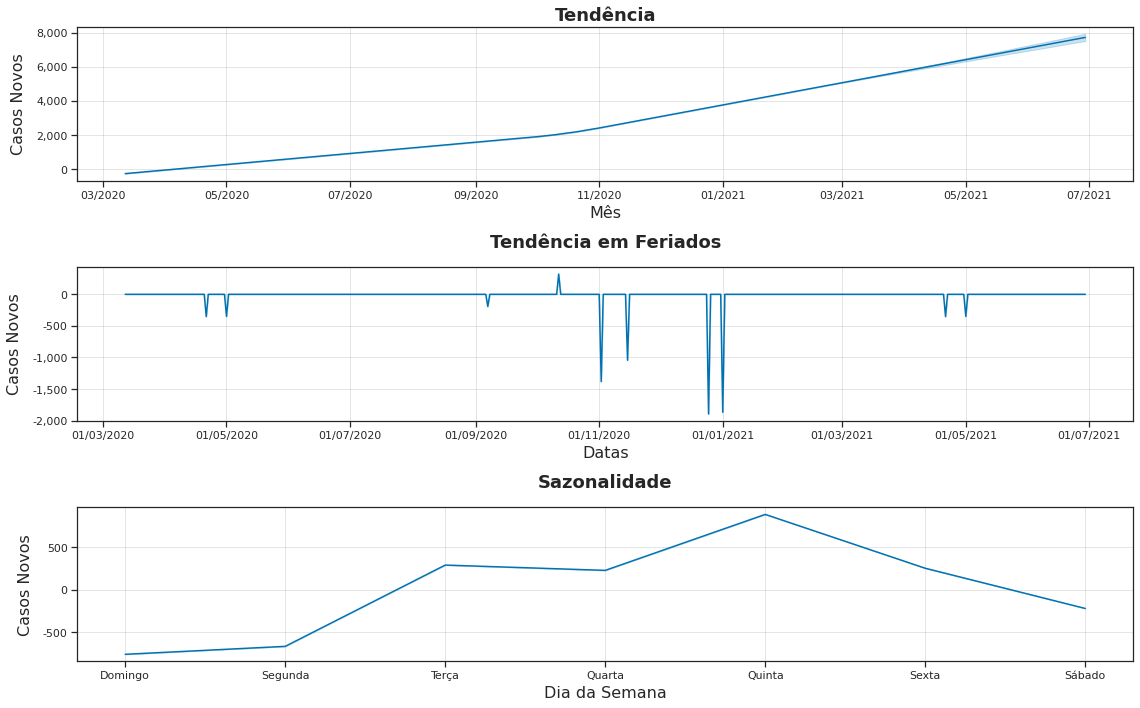

In [34]:
plotar_componentes(modelo1, previsao1)

####Resultado da 1ª Avaliação

Notamos muitos pontos de treino e de teste fora da intervalo de confiança do modelo, a linha de tendência está muito uniforme não refletindo as quebras das observações e quase não temos um "cone" de tendência.

### 2º Avaliação

Nesse segunda avaliação vamos mudar alguns parâmetros do modelo e adicionar os feriados do Estado do Paraná.

In [35]:
feriados_pr_2020 = [
'2020-02-24', '2020-02-25',
'2020-04-10', '2020-04-21',
'2020-05-01', '2020-06-11', 
'2020-09-07', '2020-10-12', 
'2020-11-02', '2020-11-15', 
'2020-12-25' ]

feriados_pr_2021 = [
'2021-01-01', '2021-04-02',
'2021-04-04', '2021-04-21', 
'2021-05-01', '2021-06-03' ]

feriados_pr_2020 = pd.DataFrame({
  'holiday': 'pr_2020',
  'ds': pd.to_datetime(feriados_pr_2020)
})

feriados_pr_2021 = pd.DataFrame({
  'holiday': 'pr_2021',
  'ds': pd.to_datetime(feriados_pr_2021)
})

feriados = pd.concat((feriados_pr_2020, feriados_pr_2021))

In [36]:
modelo2 = Prophet(n_changepoints=40, changepoint_prior_scale=10.0, seasonality_mode='multiplicative', holidays=feriados)
previsao2, dados_treino2, dados_teste2 = processar_modelo(modelo2, df, 143)

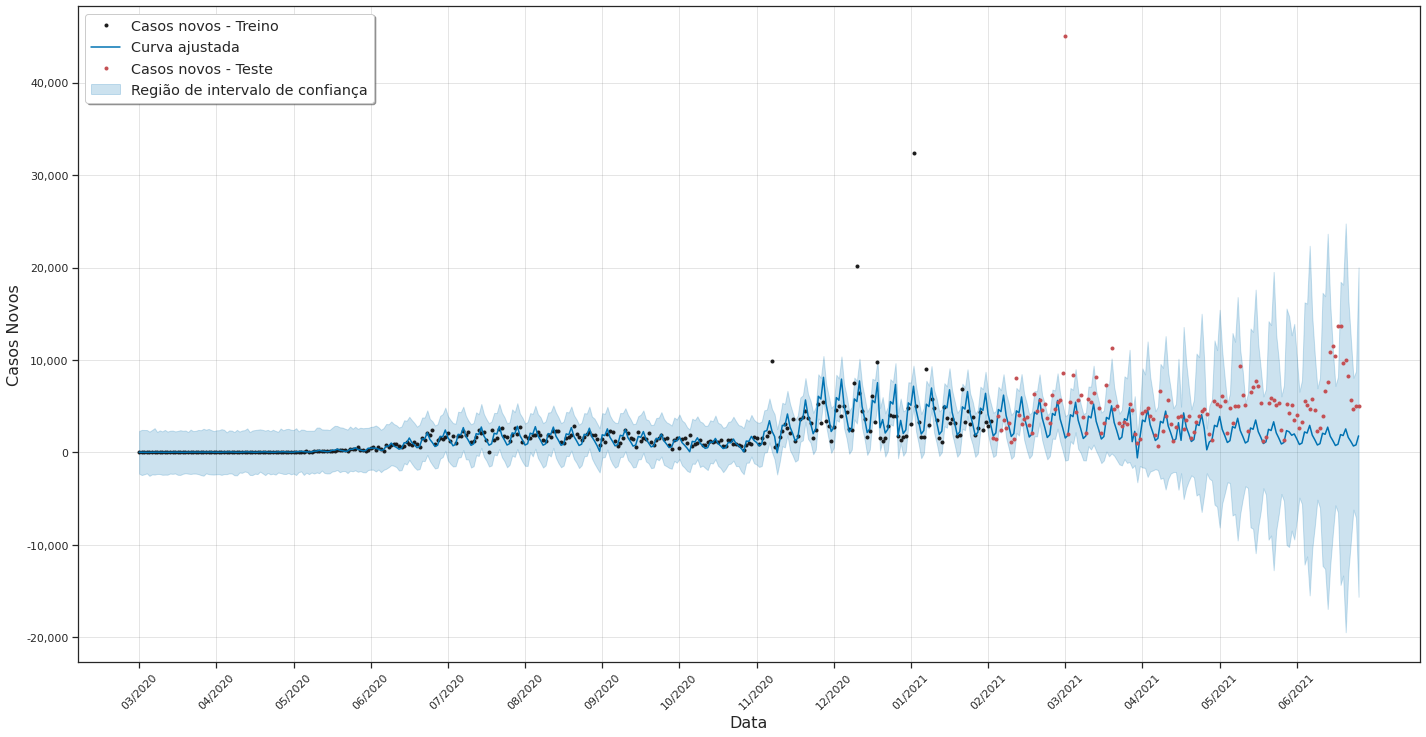

In [37]:
plotar_modelo(modelo2, previsao2, dados_teste2, False)

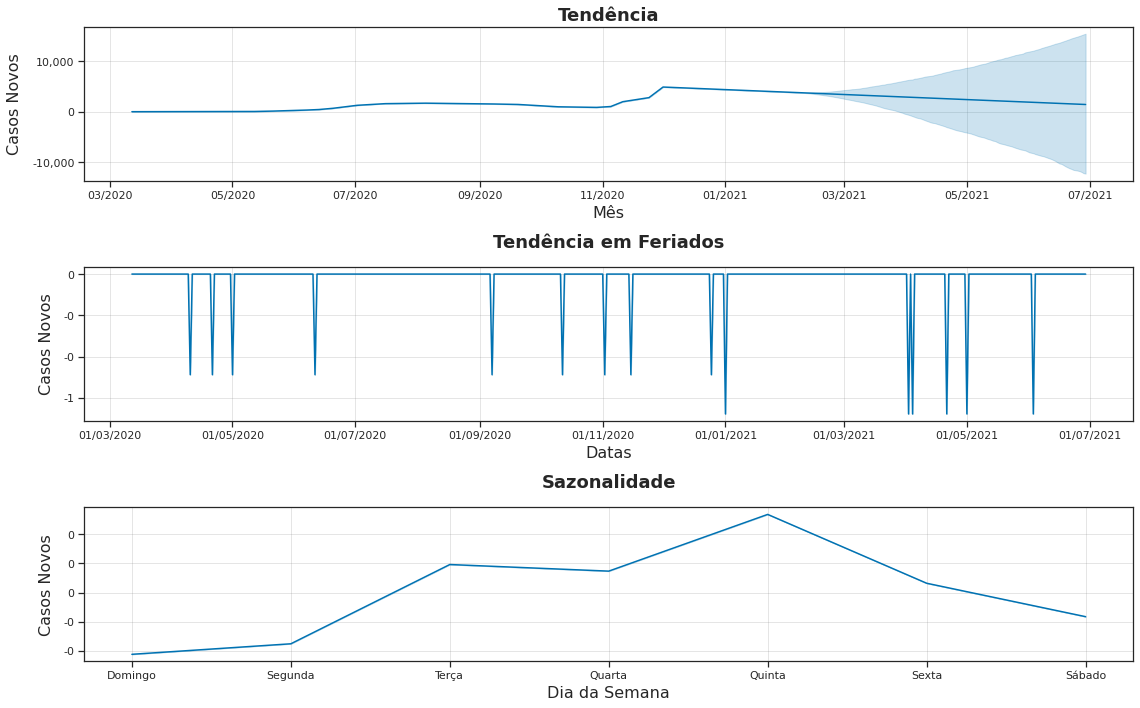

In [38]:
plotar_componentes(modelo2, previsao2)

#### Resultado da 2ª Avaliação

Já percebemos o modelo se adequar melhor aos dados de treino e teste, as tendências de feriados estão diferentes, o "cone" de tendência de casos já se ampliou e a sazonalidade permaneceu a mesma, com padrão de queda nos casos no Domingo e na Segunda-feira.

### Ajustando os dados no intervalo de confiança

Vamos remover da 2ª previsão os valores que estão fora do nosso intervalo de confiança.

In [39]:
novo_y = df.reset_index()
df_ajustado = novo_y[(novo_y['y'] > previsao2['yhat_lower'][:475]) & (novo_y['y'] < previsao2['yhat_upper'][:475])]

In [40]:
df_ajustado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450 entries, 0 to 474
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   450 non-null    int64         
 1   ds      450 non-null    datetime64[ns]
 2   y       450 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 14.1 KB


### 3º Avaliação

In [41]:
modelo3 = Prophet(n_changepoints=40, changepoint_prior_scale=10.0, seasonality_mode='multiplicative', holidays=feriados)
previsao3, dados_treino3, dados_teste3 = processar_modelo(modelo3, df_ajustado, 150)

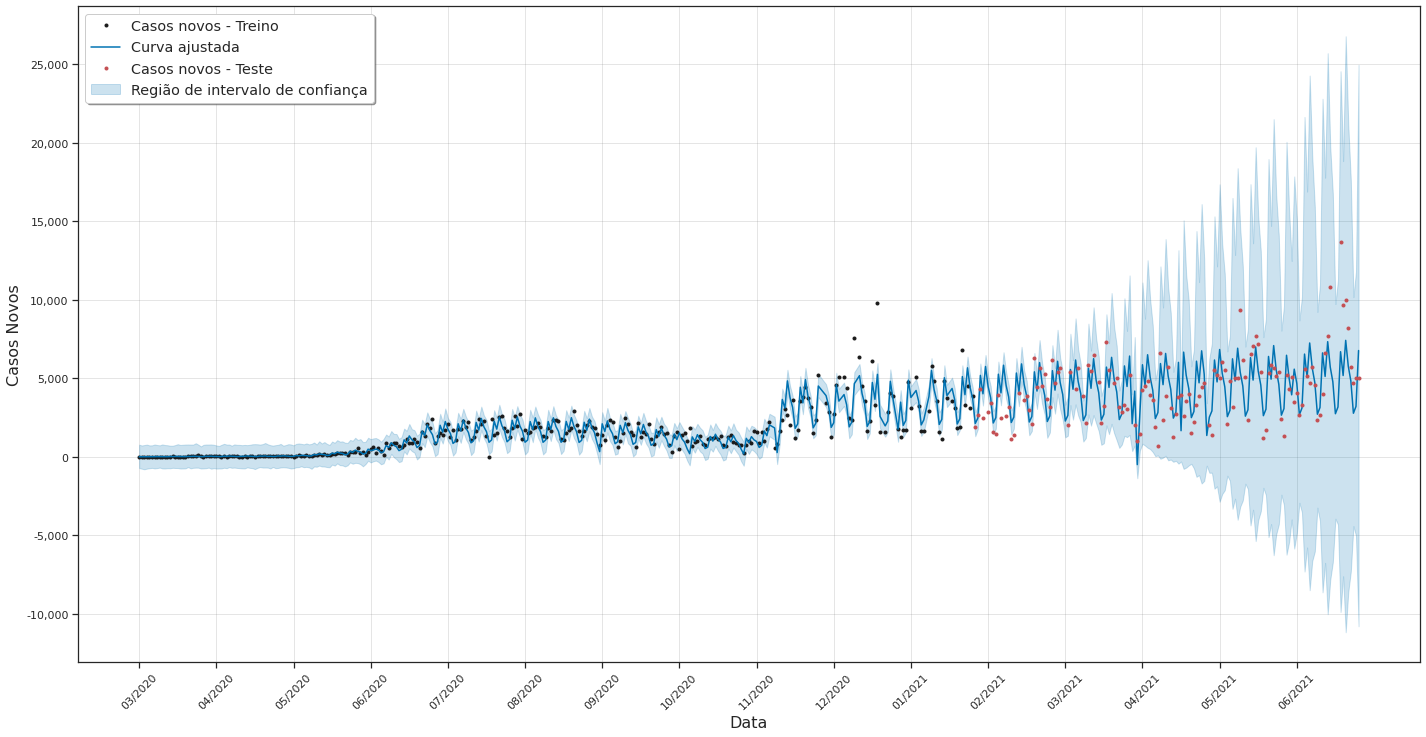

In [42]:
plotar_modelo(modelo3, previsao3, dados_teste3, False)

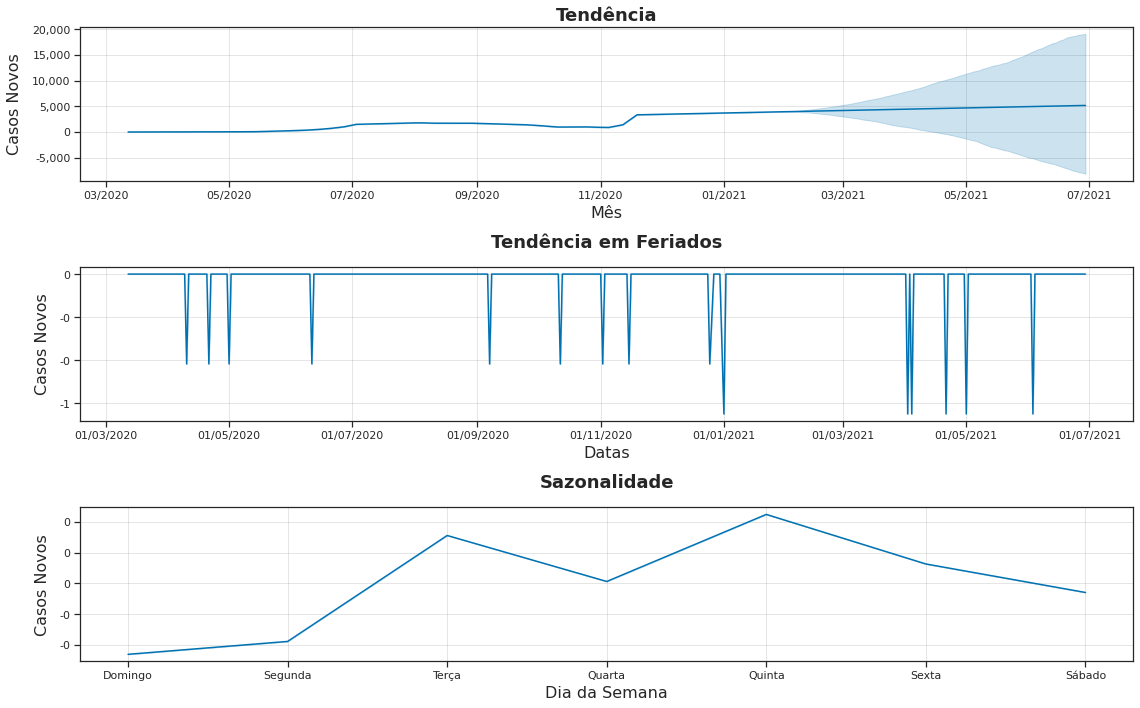

In [43]:
plotar_componentes(modelo3, previsao3)

#### Resultado da 3ª Avaliação

Os dados estão mais ajustados ao nosso modelo.

## Validando nosso modelo

In [44]:
df_cv = cross_validation(modelo3, initial = "180 days", period='30 days', horizon='30 days')

In [45]:
cutoff = df_cv['cutoff'].unique()

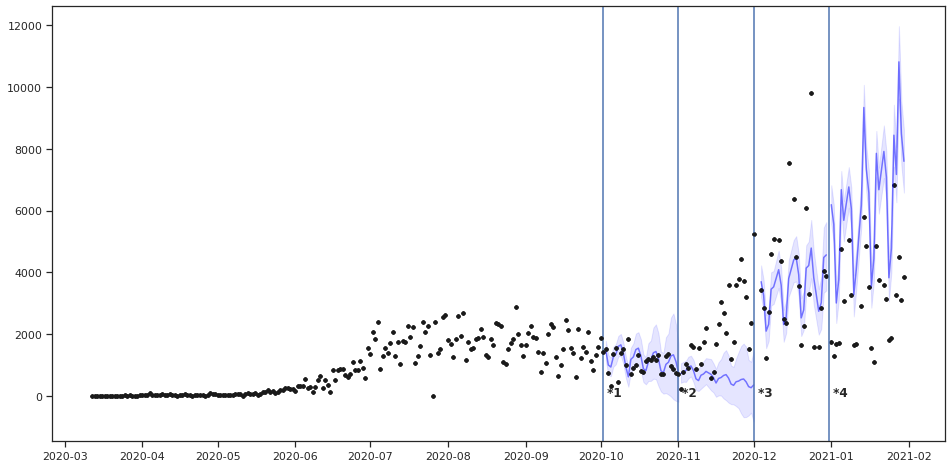

In [46]:
x=1
for i in cutoff:
  
  df_cv_cut = df_cv[df_cv['cutoff'].values == i]

  ax = plt.plot(modelo3.history['ds'].values, modelo3.history['y'], 'k.')
  plt.plot(df_cv_cut['ds'].values, df_cv_cut['yhat'], ls='-', color='blue', alpha=.5)
  plt.fill_between(df_cv_cut['ds'].values, df_cv_cut['yhat_lower'], 
                  df_cv_cut['yhat_upper'], color='blue', alpha=.1)
  plt.axvline(x=pd.to_datetime(i))
  plt.text(x=pd.to_datetime(i),y=0, s=' *'+str(x),rotation=0, weight='bold')
  x +=1

In [47]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,4 days,"2,257,241.41","1,502.41",858.62,0.72,0.20,0.64
1,5 days,"995,022.57",997.51,727.87,0.47,0.20,0.50
2,6 days,"1,548,178.89","1,244.26",953.08,0.60,0.41,0.39
3,7 days,"1,383,383.42","1,176.17",933.17,0.57,0.41,0.36
4,8 days,"1,515,107.58","1,230.90","1,002.91",0.55,0.34,0.36
5,9 days,"1,641,764.50","1,281.31",962.96,0.40,0.34,0.48
6,10 days,"1,872,991.28","1,368.57","1,140.16",0.47,0.35,0.27
7,11 days,"2,084,549.78","1,443.80","1,199.53",0.61,0.64,0.18
8,12 days,"1,612,991.39","1,270.04","1,050.50",0.57,0.59,0.24
9,13 days,"1,947,950.56","1,395.69",990.54,0.54,0.49,0.36


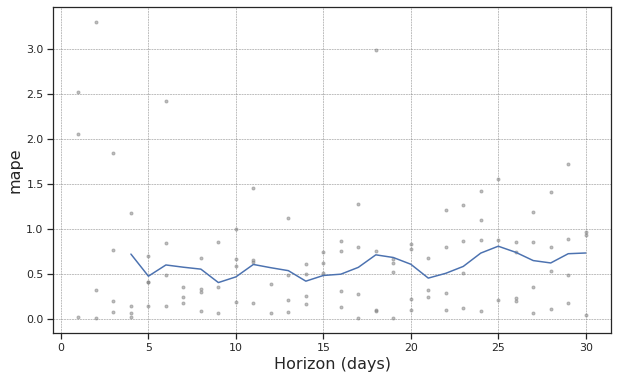

In [48]:
plot_cross_validation_metric(df_cv, metric='mape');

# Conclusão

---

Foram importados os dados do site [Brasil.IO](https://brasil.io/dataset/covid19/caso_full/) em 30/06/2021 e fizemos diversos gráficos para demonstrar a evolução do contágio da COVID-19 e consequentemente os óbitos no Estado do Paraná. Foi apresentado os gráficos de média móvel de casos e óbitos diários e realizamos estudos com o Prophet() para análise e desenvolvimento de um modelo de previsão de novos casos.

A situação é preocupante no Paraná, mesmo com o avanço da vacinação a média móvel nesse ano de 2021 aumentou consideravelmente, temos a apresentação de uma queda no final do mês de junho/2021 no gráfico de média móvel e esperamos ser uma tendência e não apenas uma falha de comunicação das informações.

O surgimento de novas cepas, a baixa cobertura vacinal no Estado (com 40% a população vacinadas com a 1ª dose e apensa 15% com a 2º dose) e a falta de conscientização da população, são desafios para que consigamos voltar ao convívio social de Janeiro de 2020.

## Sugestão de Estudo

* Desenvolver um modelo para analisar os casos de óbitos e aplicar o modelo desenvolvido nas cidades do Estado.